<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [4.1 Convexity Revisited](https://ndcbe.github.io/CBE60499/04.01-Convexity.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [4.3 Analysis of KKT Conditions](https://ndcbe.github.io/CBE60499/04.03-KKT-Multipliers.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/04.02-Local-Optimality.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/04.02-Local-Optimality.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 4.2 Local Optimality Conditions

**Reference** Section 4.2 in Biegler (2010)

## 4.2.1 Unconstrained Optimality Conditions

![picture](./figures/unconstrained_opt.png)

## 4.2.2 Karush-Kuhn-Tucker (KKT) Necessary Conditions

![picture](./figures/kkt_1.png)

![picture](./figures/kkt_2.png)

## 4.2.3 Kinematic Interpretation via Example

Consider the following two dimensional optimization problem:

$$
\begin{align} \min_{x_1,x_2} \quad & f(x) := x_1^2 - 4 x_1 + \frac{3}{2} x_2^2 -7x_2 + x_1 x_2 + 9 - \mathrm{ln}(x_1) - \mathrm{ln}(x_2) \\
\mathrm{s.t.} \quad & g(x) := 4 - x_1 x_2 \leq 0 \\
 & h(x) := 2 x_1 - x_2 = 0
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyomo.environ import *

### 4.2.3.1 Define Function for Visualization

In [2]:
## Objective function
def f(x):
    return x[0]**2 - 4*x[0] + 1.5*x[1]**2 - 7*x[1] + x[0]*x[1] + 9 - np.log(x[0]) - np.log(x[1])

## Gradient of objective f(x)
def df(x):
    return np.array((2*x[0] - 4 + x[1] - 1/x[0], 3*x[1] - 7 + x[0] - 1/x[1]))

## Gradient of inequality constraint g(x)
def dg(x):
    return np.array((-x[1], -x[0]))

## Gradient of equality constraint h(x)
def dh(x):
    return np.array([2, -1])

## Function that plots contour of objective, solution, and optionally g(x) <= 0 and h(x) = 0
def visualize(xsln,plot_g,plot_h):
    ## Create contour plot
    
    n1 = 101
    n2 = 101
    x1eval = np.linspace(0.05,10,n1)
    x2eval = np.linspace(0.05,10,n2)
    
    X, Y = np.meshgrid(x1eval, x2eval)
    
    Z = np.zeros([n2,n1])
    
    for i in range(0,n1):
        for j in range(0,n2):
            Z[j,i] = f((X[j,i], Y[j,i]))
            
    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10)
    
    ## Plot g(x) <= 0
    if(plot_g):
        g_x2 = np.zeros(n1)
        for i in range(0,n1):
            # Inverted g(x) = 0 to calculate x2 explicitly from x1
            g_x2[i] = 4 / x1eval[i]
        
        plt.plot(x1eval,g_x2,color="blue",linestyle="-.",label="$g(x) \leq 0$")
    
    ## Plot h(x) = 0
    if(plot_h):
        h_x2 = 2*x1eval
        plt.plot(x1eval,h_x2,color="red",linestyle="--",label="$h(x) = 0$")
    
    ## Plot solution
    plt.scatter(xsln[0],xsln[1],marker="*",color="black",label="$x^{*}$")
    
    ## Adjust x and y limits
    plt.xlim([-1,10])
    plt.ylim([-1,10])
    
    ## Add legend
    plt.legend()
        
## Function that draws gradient of f(x) and optionally g(x) and h(x)
def draw_gradients(x,with_g,with_h):
    dh_x = dh(x)
    
    ## Draw gradient of f(x) [objective]
    df_x = df(x)
    plt.arrow(x[0],x[1],df_x[0],df_x[1],color="black",width=0.1)
    
    ## Draw gradient of g(x) [inequality]
    if(with_g):
        dg_x = dg(x)
        plt.arrow(x[0],x[1],dg_x[0],dg_x[1],color="blue",width=0.1)
        
    ## Draw gradient of h(x) [equality]
    if(with_h):
        dh_x = dh(x)
        plt.arrow(x[0],x[1],dh_x[0],dh_x[1],color="red",width=0.1)
    
    

### 4.2.3.2 Define function to solve optimization problem with Pyomo

In [2]:
def solve_opt(consider_g,consider_h):
    
    ## Create concrete Pyomo model
    m = ConcreteModel()
    
    ## Declare variables with initial values
    m.x1 = Var(bounds=(0,100),initialize=10)
    m.x2 = Var(bounds=(0,100),initialize=10)
    
    ## Declare objective
    m.OBJ = Objective(expr=m.x1**2 - 4*m.x1 + 1.5*m.x2**2 - 7*m.x2 + m.x1 * m.x2 + 9 - log(m.x1) - log(m.x2), sense = minimize)
 
    if(consider_g):
        ## Add inequality constraint
        m.con1 = Constraint(expr=4 - m.x1*m.x2 <= 0)
        
    if(consider_h):
        ## Add equality constraint
        m.con2 = Constraint(expr=2*m.x1 - m.x2 == 0)
    
    ## Specify IPOPT as solver
    solver = SolverFactory('ipopt')

    ## Solve the model
    results = solver.solve(m, tee = True)
    
    ## Return the solution
    return [value(m.x1),value(m.x2)]
    

### 4.2.3.3 Take 1: Unconstrained

Ipopt 3.12.10: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Tot

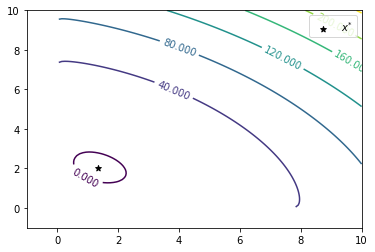

In [4]:
# Solve optimization problem
xsln = solve_opt(False,False)

# Create contour plot
visualize(xsln,False,False)

plt.show()

### 4.2.3.4 Take 2. With $g(x) \leq 0$

Ipopt 3.12.10: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Tot

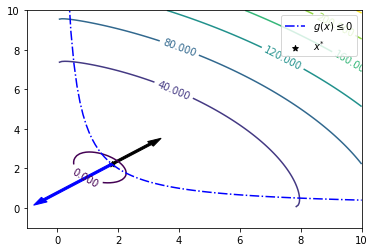

In [5]:
# Solve optimization problem
xsln = solve_opt(True,False)

# Create contour plot
visualize(xsln,True,False)

# Draw gradient
draw_gradients(xsln,True,False)

plt.show()

### 4.2.3.5 Take 3. With $g(x) \leq 0$ and $h(x) = 0$

Ipopt 3.12.10: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Tot

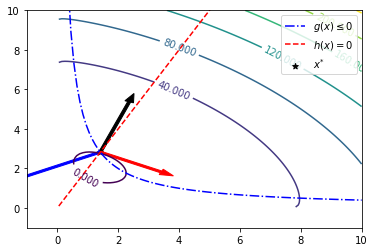

In [6]:
# Solve optimization problem
xsln = solve_opt(True,True)

# Create contour plot
visualize(xsln,True,True)

# Draw gradient
draw_gradients(xsln,True,True)

plt.show()

### 4.2.3.6 Discussion

Why are the gradient vectors not the same length? I thought the forces were balanced...

### 4.2.3.7 Analysis without Constraints

![picture](./figures/unconstrained_analysis.png)

### 4.2.3.8 Analysis with Constraints

![picture](./figures/constrained_analysis.png)

<!--NAVIGATION-->
< [4.1 Convexity Revisited](https://ndcbe.github.io/CBE60499/04.01-Convexity.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [4.3 Analysis of KKT Conditions](https://ndcbe.github.io/CBE60499/04.03-KKT-Multipliers.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/04.02-Local-Optimality.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/04.02-Local-Optimality.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>